In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_0_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(553799, 828)
(553799, 1)
validation
(80986, 828)
(80986, 1)
test
(65261, 828)
(65261, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/56 [..............................] - ETA: 1:09 - loss: 0.2064 - STD: 2.0597e-04 - MAE: 0.4381

 2/56 [>.............................] - ETA: 27s - loss: 0.1640 - STD: 4.6848e-04 - MAE: 0.3289 

 5/56 [=>............................] - ETA: 7s - loss: 0.0690 - STD: 4.2485e-04 - MAE: 0.1959 

 6/56 [==>...........................] - ETA: 6s - loss: 0.0638 - STD: 3.7287e-04 - MAE: 0.1899

 7/56 [==>...........................] - ETA: 6s - loss: 0.0607 - STD: 3.3009e-04 - MAE: 0.1870

 8/56 [===>..........................] - ETA: 5s - loss: 0.0587 - STD: 2.9601e-04 - MAE: 0.1853

 9/56 [===>..........................] - ETA: 5s - loss: 0.0570 - STD: 2.6901e-04 - MAE: 0.1837

10/56 [====>.........................] - ETA: 4s - loss: 0.0556 - STD: 2.4817e-04 - MAE: 0.1822

11/56 [====>.........................] - ETA: 4s - loss: 0.0542 - STD: 2.3224e-04 - MAE: 0.1801

12/56 [=====>........................] - ETA: 4s - loss: 0.0528 - STD: 2.2022e-04 - MAE: 0.1777

13/56 [=====>........................] - ETA: 4s - loss: 0.0513 - STD: 2.1150e-04 - MAE: 0.1746

14/56 [======>.......................] - ETA: 3s - loss: 0.0496 - STD: 2.0546e-04 - MAE: 0.1705

15/56 [=======>......................] - ETA: 3s - loss: 0.0479 - STD: 2.0190e-04 - MAE: 0.1657

16/56 [=======>......................] - ETA: 3s - loss: 0.0461 - STD: 2.0001e-04 - MAE: 0.1603

17/56 [========>.....................] - ETA: 3s - loss: 0.0443 - STD: 1.9937e-04 - MAE: 0.1549

18/56 [========>.....................] - ETA: 3s - loss: 0.0426 - STD: 1.9963e-04 - MAE: 0.1505

19/56 [=========>....................] - ETA: 3s - loss: 0.0412 - STD: 2.0010e-04 - MAE: 0.1474

20/56 [=========>....................] - ETA: 3s - loss: 0.0400 - STD: 2.0078e-04 - MAE: 0.1455

21/56 [==========>...................] - ETA: 3s - loss: 0.0390 - STD: 2.0122e-04 - MAE: 0.1444

22/56 [==========>...................] - ETA: 2s - loss: 0.0382 - STD: 2.0154e-04 - MAE: 0.1439

23/56 [===========>..................] - ETA: 2s - loss: 0.0375 - STD: 2.0172e-04 - MAE: 0.1434

24/56 [===========>..................] - ETA: 2s - loss: 0.0368 - STD: 2.0159e-04 - MAE: 0.1428

25/56 [============>.................] - ETA: 2s - loss: 0.0361 - STD: 2.0132e-04 - MAE: 0.1420

26/56 [============>.................] - ETA: 2s - loss: 0.0353 - STD: 2.0064e-04 - MAE: 0.1408

27/56 [=============>................] - ETA: 2s - loss: 0.0346 - STD: 1.9978e-04 - MAE: 0.1393

28/56 [==============>...............] - ETA: 2s - loss: 0.0340 - STD: 1.9880e-04 - MAE: 0.1375

29/56 [==============>...............] - ETA: 2s - loss: 0.0333 - STD: 1.9747e-04 - MAE: 0.1355

30/56 [===============>..............] - ETA: 2s - loss: 0.0327 - STD: 1.9612e-04 - MAE: 0.1334

31/56 [===============>..............] - ETA: 2s - loss: 0.0322 - STD: 1.9466e-04 - MAE: 0.1313

32/56 [================>.............] - ETA: 1s - loss: 0.0317 - STD: 1.9319e-04 - MAE: 0.1294

33/56 [================>.............] - ETA: 1s - loss: 0.0312 - STD: 1.9171e-04 - MAE: 0.1276

34/56 [=================>............] - ETA: 1s - loss: 0.0308 - STD: 1.9030e-04 - MAE: 0.1259

35/56 [=================>............] - ETA: 1s - loss: 0.0304 - STD: 1.8900e-04 - MAE: 0.1243

36/56 [==================>...........] - ETA: 1s - loss: 0.0301 - STD: 1.8792e-04 - MAE: 0.1227

37/56 [==================>...........] - ETA: 1s - loss: 0.0297 - STD: 1.8698e-04 - MAE: 0.1213

38/56 [===================>..........] - ETA: 1s - loss: 0.0293 - STD: 1.8630e-04 - MAE: 0.1199

39/56 [===================>..........] - ETA: 1s - loss: 0.0290 - STD: 1.8573e-04 - MAE: 0.1187

40/56 [====================>.........] - ETA: 1s - loss: 0.0286 - STD: 1.8537e-04 - MAE: 0.1176

41/56 [====================>.........] - ETA: 1s - loss: 0.0283 - STD: 1.8523e-04 - MAE: 0.1167

42/56 [=====================>........] - ETA: 1s - loss: 0.0280 - STD: 1.8525e-04 - MAE: 0.1159

43/56 [======================>.......] - ETA: 1s - loss: 0.0277 - STD: 1.8540e-04 - MAE: 0.1153

44/56 [======================>.......] - ETA: 0s - loss: 0.0274 - STD: 1.8576e-04 - MAE: 0.1148

45/56 [=======================>......] - ETA: 0s - loss: 0.0272 - STD: 1.8623e-04 - MAE: 0.1143

46/56 [=======================>......] - ETA: 0s - loss: 0.0269 - STD: 1.8682e-04 - MAE: 0.1139

47/56 [========================>.....] - ETA: 0s - loss: 0.0267 - STD: 1.8745e-04 - MAE: 0.1134

48/56 [========================>.....] - ETA: 0s - loss: 0.0265 - STD: 1.8818e-04 - MAE: 0.1130

49/56 [=========================>....] - ETA: 0s - loss: 0.0262 - STD: 1.8896e-04 - MAE: 0.1126

50/56 [=========================>....] - ETA: 0s - loss: 0.0260 - STD: 1.8971e-04 - MAE: 0.1120

51/56 [==========================>...] - ETA: 0s - loss: 0.0258 - STD: 1.9057e-04 - MAE: 0.1115

52/56 [==========================>...] - ETA: 0s - loss: 0.0256 - STD: 1.9150e-04 - MAE: 0.1109

53/56 [===========================>..] - ETA: 0s - loss: 0.0254 - STD: 1.9246e-04 - MAE: 0.1103

54/56 [===========================>..] - ETA: 0s - loss: 0.0252 - STD: 1.9346e-04 - MAE: 0.1097

55/56 [============================>.] - ETA: 0s - loss: 0.0251 - STD: 1.9453e-04 - MAE: 0.1091

56/56 [==============================] - ETA: 0s - loss: 0.0249 - STD: 1.9571e-04 - MAE: 0.1085

56/56 [==============================] - 6s 88ms/step - loss: 0.0249 - STD: 1.9571e-04 - MAE: 0.1085 - val_loss: 0.0208 - val_STD: 2.4865e-04 - val_MAE: 0.0806


Epoch 2/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0149 - STD: 2.6691e-04 - MAE: 0.0733

 2/56 [>.............................] - ETA: 4s - loss: 0.0154 - STD: 2.7430e-04 - MAE: 0.0743

 3/56 [>.............................] - ETA: 3s - loss: 0.0156 - STD: 2.8048e-04 - MAE: 0.0751

 4/56 [=>............................] - ETA: 3s - loss: 0.0157 - STD: 2.8665e-04 - MAE: 0.0757

 5/56 [=>............................] - ETA: 3s - loss: 0.0157 - STD: 2.9333e-04 - MAE: 0.0763

 6/56 [==>...........................] - ETA: 3s - loss: 0.0157 - STD: 3.0004e-04 - MAE: 0.0770

 7/56 [==>...........................] - ETA: 3s - loss: 0.0156 - STD: 3.0727e-04 - MAE: 0.0776

 8/56 [===>..........................] - ETA: 3s - loss: 0.0156 - STD: 3.1466e-04 - MAE: 0.0783

 9/56 [===>..........................] - ETA: 3s - loss: 0.0156 - STD: 3.2256e-04 - MAE: 0.0790

10/56 [====>.........................] - ETA: 3s - loss: 0.0156 - STD: 3.3091e-04 - MAE: 0.0797

11/56 [====>.........................] - ETA: 3s - loss: 0.0156 - STD: 3.3924e-04 - MAE: 0.0803

12/56 [=====>........................] - ETA: 3s - loss: 0.0157 - STD: 3.4751e-04 - MAE: 0.0808

13/56 [=====>........................] - ETA: 2s - loss: 0.0156 - STD: 3.5575e-04 - MAE: 0.0811

15/56 [=======>......................] - ETA: 2s - loss: 0.0157 - STD: 3.7329e-04 - MAE: 0.0815

16/56 [=======>......................] - ETA: 2s - loss: 0.0157 - STD: 3.8218e-04 - MAE: 0.0817

17/56 [========>.....................] - ETA: 2s - loss: 0.0157 - STD: 3.9114e-04 - MAE: 0.0817

18/56 [========>.....................] - ETA: 2s - loss: 0.0157 - STD: 4.0044e-04 - MAE: 0.0817

19/56 [=========>....................] - ETA: 2s - loss: 0.0157 - STD: 4.1011e-04 - MAE: 0.0817

20/56 [=========>....................] - ETA: 2s - loss: 0.0157 - STD: 4.1996e-04 - MAE: 0.0815

21/56 [==========>...................] - ETA: 2s - loss: 0.0156 - STD: 4.3063e-04 - MAE: 0.0814

22/56 [==========>...................] - ETA: 2s - loss: 0.0156 - STD: 4.4185e-04 - MAE: 0.0812

23/56 [===========>..................] - ETA: 2s - loss: 0.0156 - STD: 4.5377e-04 - MAE: 0.0811

24/56 [===========>..................] - ETA: 2s - loss: 0.0156 - STD: 4.6608e-04 - MAE: 0.0811

25/56 [============>.................] - ETA: 2s - loss: 0.0156 - STD: 4.7911e-04 - MAE: 0.0810

26/56 [============>.................] - ETA: 2s - loss: 0.0156 - STD: 4.9294e-04 - MAE: 0.0810

27/56 [=============>................] - ETA: 1s - loss: 0.0155 - STD: 5.0719e-04 - MAE: 0.0809

28/56 [==============>...............] - ETA: 1s - loss: 0.0155 - STD: 5.2220e-04 - MAE: 0.0808

29/56 [==============>...............] - ETA: 1s - loss: 0.0155 - STD: 5.3856e-04 - MAE: 0.0809

30/56 [===============>..............] - ETA: 1s - loss: 0.0155 - STD: 5.5558e-04 - MAE: 0.0809

31/56 [===============>..............] - ETA: 1s - loss: 0.0155 - STD: 5.7357e-04 - MAE: 0.0809

32/56 [================>.............] - ETA: 1s - loss: 0.0155 - STD: 5.9227e-04 - MAE: 0.0809

33/56 [================>.............] - ETA: 1s - loss: 0.0155 - STD: 6.1225e-04 - MAE: 0.0809

34/56 [=================>............] - ETA: 1s - loss: 0.0155 - STD: 6.3302e-04 - MAE: 0.0809

35/56 [=================>............] - ETA: 1s - loss: 0.0155 - STD: 6.5511e-04 - MAE: 0.0809

36/56 [==================>...........] - ETA: 1s - loss: 0.0155 - STD: 6.7857e-04 - MAE: 0.0809

37/56 [==================>...........] - ETA: 1s - loss: 0.0155 - STD: 7.0318e-04 - MAE: 0.0809

38/56 [===================>..........] - ETA: 1s - loss: 0.0155 - STD: 7.2895e-04 - MAE: 0.0808

39/56 [===================>..........] - ETA: 1s - loss: 0.0154 - STD: 7.5637e-04 - MAE: 0.0808

40/56 [====================>.........] - ETA: 1s - loss: 0.0154 - STD: 7.8510e-04 - MAE: 0.0808

41/56 [====================>.........] - ETA: 1s - loss: 0.0154 - STD: 8.1582e-04 - MAE: 0.0807

42/56 [=====================>........] - ETA: 0s - loss: 0.0154 - STD: 8.4771e-04 - MAE: 0.0807

43/56 [======================>.......] - ETA: 0s - loss: 0.0154 - STD: 8.8214e-04 - MAE: 0.0807

44/56 [======================>.......] - ETA: 0s - loss: 0.0154 - STD: 9.1837e-04 - MAE: 0.0807

45/56 [=======================>......] - ETA: 0s - loss: 0.0154 - STD: 9.5675e-04 - MAE: 0.0807

46/56 [=======================>......] - ETA: 0s - loss: 0.0154 - STD: 9.9777e-04 - MAE: 0.0806

47/56 [========================>.....] - ETA: 0s - loss: 0.0154 - STD: 0.0010 - MAE: 0.0806    

48/56 [========================>.....] - ETA: 0s - loss: 0.0154 - STD: 0.0011 - MAE: 0.0807

49/56 [=========================>....] - ETA: 0s - loss: 0.0154 - STD: 0.0011 - MAE: 0.0807

50/56 [=========================>....] - ETA: 0s - loss: 0.0154 - STD: 0.0012 - MAE: 0.0806

51/56 [==========================>...] - ETA: 0s - loss: 0.0154 - STD: 0.0012 - MAE: 0.0807

52/56 [==========================>...] - ETA: 0s - loss: 0.0154 - STD: 0.0013 - MAE: 0.0806

53/56 [===========================>..] - ETA: 0s - loss: 0.0154 - STD: 0.0014 - MAE: 0.0806

54/56 [===========================>..] - ETA: 0s - loss: 0.0154 - STD: 0.0014 - MAE: 0.0806

55/56 [============================>.] - ETA: 0s - loss: 0.0153 - STD: 0.0015 - MAE: 0.0806

56/56 [==============================] - ETA: 0s - loss: 0.0153 - STD: 0.0016 - MAE: 0.0805

56/56 [==============================] - 4s 72ms/step - loss: 0.0153 - STD: 0.0016 - MAE: 0.0805 - val_loss: 0.0191 - val_STD: 0.0057 - val_MAE: 0.0830


Epoch 3/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0140 - STD: 0.0063 - MAE: 0.0774

 2/56 [>.............................] - ETA: 3s - loss: 0.0141 - STD: 0.0065 - MAE: 0.0774

 3/56 [>.............................] - ETA: 3s - loss: 0.0142 - STD: 0.0068 - MAE: 0.0774

 4/56 [=>............................] - ETA: 3s - loss: 0.0142 - STD: 0.0070 - MAE: 0.0772

 5/56 [=>............................] - ETA: 3s - loss: 0.0142 - STD: 0.0073 - MAE: 0.0771

 6/56 [==>...........................] - ETA: 3s - loss: 0.0142 - STD: 0.0076 - MAE: 0.0772

 7/56 [==>...........................] - ETA: 3s - loss: 0.0141 - STD: 0.0080 - MAE: 0.0770

 8/56 [===>..........................] - ETA: 3s - loss: 0.0141 - STD: 0.0083 - MAE: 0.0769

 9/56 [===>..........................] - ETA: 3s - loss: 0.0140 - STD: 0.0087 - MAE: 0.0769

10/56 [====>.........................] - ETA: 3s - loss: 0.0140 - STD: 0.0090 - MAE: 0.0767

11/56 [====>.........................] - ETA: 3s - loss: 0.0140 - STD: 0.0095 - MAE: 0.0766

12/56 [=====>........................] - ETA: 3s - loss: 0.0139 - STD: 0.0099 - MAE: 0.0765

13/56 [=====>........................] - ETA: 2s - loss: 0.0139 - STD: 0.0103 - MAE: 0.0764

14/56 [======>.......................] - ETA: 2s - loss: 0.0138 - STD: 0.0108 - MAE: 0.0761

15/56 [=======>......................] - ETA: 2s - loss: 0.0137 - STD: 0.0113 - MAE: 0.0758

16/56 [=======>......................] - ETA: 2s - loss: 0.0136 - STD: 0.0118 - MAE: 0.0756

17/56 [========>.....................] - ETA: 2s - loss: 0.0135 - STD: 0.0123 - MAE: 0.0752

18/56 [========>.....................] - ETA: 2s - loss: 0.0134 - STD: 0.0129 - MAE: 0.0749

19/56 [=========>....................] - ETA: 2s - loss: 0.0133 - STD: 0.0135 - MAE: 0.0746

20/56 [=========>....................] - ETA: 2s - loss: 0.0132 - STD: 0.0141 - MAE: 0.0743

21/56 [==========>...................] - ETA: 2s - loss: 0.0131 - STD: 0.0148 - MAE: 0.0740

22/56 [==========>...................] - ETA: 2s - loss: 0.0130 - STD: 0.0155 - MAE: 0.0737

23/56 [===========>..................] - ETA: 2s - loss: 0.0129 - STD: 0.0162 - MAE: 0.0734

24/56 [===========>..................] - ETA: 2s - loss: 0.0128 - STD: 0.0169 - MAE: 0.0731

25/56 [============>.................] - ETA: 2s - loss: 0.0127 - STD: 0.0177 - MAE: 0.0728

26/56 [============>.................] - ETA: 2s - loss: 0.0126 - STD: 0.0185 - MAE: 0.0725

27/56 [=============>................] - ETA: 2s - loss: 0.0125 - STD: 0.0194 - MAE: 0.0721

28/56 [==============>...............] - ETA: 1s - loss: 0.0124 - STD: 0.0202 - MAE: 0.0717

29/56 [==============>...............] - ETA: 1s - loss: 0.0123 - STD: 0.0211 - MAE: 0.0713

30/56 [===============>..............] - ETA: 1s - loss: 0.0121 - STD: 0.0220 - MAE: 0.0708

31/56 [===============>..............] - ETA: 1s - loss: 0.0120 - STD: 0.0229 - MAE: 0.0704

32/56 [================>.............] - ETA: 1s - loss: 0.0119 - STD: 0.0239 - MAE: 0.0700

33/56 [================>.............] - ETA: 1s - loss: 0.0118 - STD: 0.0249 - MAE: 0.0695

34/56 [=================>............] - ETA: 1s - loss: 0.0116 - STD: 0.0259 - MAE: 0.0691

35/56 [=================>............] - ETA: 1s - loss: 0.0115 - STD: 0.0270 - MAE: 0.0686

36/56 [==================>...........] - ETA: 1s - loss: 0.0114 - STD: 0.0280 - MAE: 0.0682

37/56 [==================>...........] - ETA: 1s - loss: 0.0113 - STD: 0.0291 - MAE: 0.0677

38/56 [===================>..........] - ETA: 1s - loss: 0.0111 - STD: 0.0303 - MAE: 0.0672

39/56 [===================>..........] - ETA: 1s - loss: 0.0110 - STD: 0.0314 - MAE: 0.0668

40/56 [====================>.........] - ETA: 1s - loss: 0.0109 - STD: 0.0324 - MAE: 0.0663

41/56 [====================>.........] - ETA: 1s - loss: 0.0107 - STD: 0.0335 - MAE: 0.0658

42/56 [=====================>........] - ETA: 0s - loss: 0.0106 - STD: 0.0346 - MAE: 0.0654

43/56 [======================>.......] - ETA: 0s - loss: 0.0105 - STD: 0.0358 - MAE: 0.0650

44/56 [======================>.......] - ETA: 0s - loss: 0.0104 - STD: 0.0369 - MAE: 0.0645

45/56 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 0.0380 - MAE: 0.0641

46/56 [=======================>......] - ETA: 0s - loss: 0.0101 - STD: 0.0391 - MAE: 0.0637

47/56 [========================>.....] - ETA: 0s - loss: 0.0100 - STD: 0.0401 - MAE: 0.0633

48/56 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 0.0412 - MAE: 0.0628

49/56 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 0.0422 - MAE: 0.0625

50/56 [=========================>....] - ETA: 0s - loss: 0.0097 - STD: 0.0433 - MAE: 0.0621

51/56 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 0.0444 - MAE: 0.0617

53/56 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 0.0464 - MAE: 0.0610

54/56 [===========================>..] - ETA: 0s - loss: 0.0094 - STD: 0.0474 - MAE: 0.0606

55/56 [============================>.] - ETA: 0s - loss: 0.0093 - STD: 0.0483 - MAE: 0.0603

56/56 [==============================] - ETA: 0s - loss: 0.0092 - STD: 0.0492 - MAE: 0.0600

56/56 [==============================] - 4s 74ms/step - loss: 0.0092 - STD: 0.0492 - MAE: 0.0600 - val_loss: 0.0057 - val_STD: 0.0894 - val_MAE: 0.0463


Epoch 4/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0985 - MAE: 0.0407

 2/56 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.1003 - MAE: 0.0410

 3/56 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.1008 - MAE: 0.0410

 4/56 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.1016 - MAE: 0.0411

 5/56 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.1017 - MAE: 0.0410

 6/56 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.1021 - MAE: 0.0409

 7/56 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.1022 - MAE: 0.0410

 8/56 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.1025 - MAE: 0.0409

 9/56 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.1030 - MAE: 0.0409

10/56 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.1032 - MAE: 0.0408

11/56 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.1030 - MAE: 0.0408

12/56 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.1031 - MAE: 0.0407

13/56 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.1032 - MAE: 0.0406

14/56 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.1033 - MAE: 0.0405

15/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.1035 - MAE: 0.0404

16/56 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.1037 - MAE: 0.0404

17/56 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.1038 - MAE: 0.0403

18/56 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.1038 - MAE: 0.0402

19/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.1038 - MAE: 0.0401

20/56 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.1037 - MAE: 0.0401

21/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.1039 - MAE: 0.0400

22/56 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.1041 - MAE: 0.0400

23/56 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.1042 - MAE: 0.0399

24/56 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.1043 - MAE: 0.0398

25/56 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.1044 - MAE: 0.0398

27/56 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.1047 - MAE: 0.0397

28/56 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.1049 - MAE: 0.0396

29/56 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.1048 - MAE: 0.0396

30/56 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.1048 - MAE: 0.0395

31/56 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.1049 - MAE: 0.0395

32/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.1051 - MAE: 0.0394

33/56 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.1051 - MAE: 0.0394

34/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.1052 - MAE: 0.0393

35/56 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.1052 - MAE: 0.0393

36/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.1053 - MAE: 0.0392

37/56 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.1055 - MAE: 0.0392

38/56 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.1055 - MAE: 0.0391

39/56 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.1055 - MAE: 0.0391

40/56 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.1056 - MAE: 0.0390

41/56 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.1058 - MAE: 0.0390

42/56 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.1059 - MAE: 0.0389

43/56 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.1059 - MAE: 0.0389

44/56 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.1060 - MAE: 0.0389

45/56 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.1060 - MAE: 0.0388

46/56 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.1062 - MAE: 0.0388

47/56 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.1062 - MAE: 0.0387

48/56 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.1062 - MAE: 0.0387

49/56 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.1061 - MAE: 0.0386

50/56 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.1062 - MAE: 0.0386

51/56 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.1064 - MAE: 0.0385

52/56 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.1064 - MAE: 0.0385

53/56 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.1064 - MAE: 0.0384

54/56 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.1064 - MAE: 0.0384

55/56 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.1066 - MAE: 0.0383

56/56 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.1068 - MAE: 0.0383

56/56 [==============================] - 4s 72ms/step - loss: 0.0035 - STD: 0.1068 - MAE: 0.0383 - val_loss: 0.0030 - val_STD: 0.1011 - val_MAE: 0.0370


Epoch 5/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.1050 - MAE: 0.0354

 2/56 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0358

 3/56 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.1083 - MAE: 0.0357

 4/56 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.1095 - MAE: 0.0358

 5/56 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.1089 - MAE: 0.0357

 6/56 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.1087 - MAE: 0.0355

 7/56 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.1098 - MAE: 0.0355

 8/56 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.1098 - MAE: 0.0354

 9/56 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1094 - MAE: 0.0353

10/56 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.1092 - MAE: 0.0352

11/56 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.1094 - MAE: 0.0352

12/56 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.1094 - MAE: 0.0352

13/56 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.1095 - MAE: 0.0351

14/56 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.1094 - MAE: 0.0351

15/56 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1096 - MAE: 0.0351

16/56 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1101 - MAE: 0.0350

17/56 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1100 - MAE: 0.0350

18/56 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1100 - MAE: 0.0350

19/56 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1100 - MAE: 0.0349

20/56 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1101 - MAE: 0.0349

21/56 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.1102 - MAE: 0.0348

22/56 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.1102 - MAE: 0.0348

24/56 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1102 - MAE: 0.0348

25/56 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1102 - MAE: 0.0347

26/56 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1105 - MAE: 0.0347

27/56 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1105 - MAE: 0.0347

28/56 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1106 - MAE: 0.0347

29/56 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1106 - MAE: 0.0346

30/56 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1106 - MAE: 0.0346

31/56 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1106 - MAE: 0.0346

32/56 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1105 - MAE: 0.0345

33/56 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1105 - MAE: 0.0345

34/56 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1106 - MAE: 0.0345

35/56 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1106 - MAE: 0.0345

36/56 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1106 - MAE: 0.0344

37/56 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1107 - MAE: 0.0344

38/56 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1107 - MAE: 0.0344

39/56 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1108 - MAE: 0.0344

40/56 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1108 - MAE: 0.0344

41/56 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1109 - MAE: 0.0343

42/56 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1109 - MAE: 0.0343

43/56 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1109 - MAE: 0.0343

44/56 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1109 - MAE: 0.0343

45/56 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1110 - MAE: 0.0343

46/56 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1110 - MAE: 0.0343

47/56 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1112 - MAE: 0.0342

48/56 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1113 - MAE: 0.0342

49/56 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1113 - MAE: 0.0342

50/56 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1113 - MAE: 0.0342

51/56 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1113 - MAE: 0.0342

52/56 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1113 - MAE: 0.0341

53/56 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1113 - MAE: 0.0341

54/56 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1114 - MAE: 0.0341

55/56 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1115 - MAE: 0.0341

56/56 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1114 - MAE: 0.0341

56/56 [==============================] - 4s 73ms/step - loss: 0.0026 - STD: 0.1114 - MAE: 0.0341 - val_loss: 0.0023 - val_STD: 0.1066 - val_MAE: 0.0329


Epoch 6/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.1075 - MAE: 0.0330

 2/56 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1114 - MAE: 0.0330

 3/56 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1118 - MAE: 0.0332

 4/56 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1112 - MAE: 0.0331

 5/56 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1115 - MAE: 0.0331

 6/56 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1122 - MAE: 0.0331

 7/56 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1125 - MAE: 0.0331

 8/56 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1126 - MAE: 0.0331

 9/56 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1127 - MAE: 0.0331

10/56 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0331

11/56 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1130 - MAE: 0.0331

12/56 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.1130 - MAE: 0.0330

13/56 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.1131 - MAE: 0.0329

14/56 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1132 - MAE: 0.0329

15/56 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1132 - MAE: 0.0329

16/56 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0329

17/56 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0329

18/56 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0329

19/56 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0329

20/56 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0329

21/56 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0329

22/56 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1132 - MAE: 0.0329

23/56 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0329

24/56 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1132 - MAE: 0.0329

25/56 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0329

26/56 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1136 - MAE: 0.0329

27/56 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0329

28/56 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0329

29/56 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0329

30/56 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0329

31/56 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0328

32/56 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0328

33/56 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0328

34/56 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0328

35/56 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0328

36/56 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0328

37/56 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0328

38/56 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0328

39/56 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0328

40/56 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0328

41/56 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0328

43/56 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0328

44/56 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0327

45/56 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0327

46/56 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0327

47/56 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0327

48/56 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0327

49/56 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0328

50/56 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0327

51/56 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0327

52/56 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0327

53/56 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0327

54/56 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0327

55/56 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0327

56/56 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0327

56/56 [==============================] - 4s 73ms/step - loss: 0.0024 - STD: 0.1134 - MAE: 0.0327 - val_loss: 0.0022 - val_STD: 0.1074 - val_MAE: 0.0322


Epoch 7/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0318

 2/56 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.1161 - MAE: 0.0328

 3/56 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0326

 4/56 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1136 - MAE: 0.0327

 5/56 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1148 - MAE: 0.0325

 6/56 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1158 - MAE: 0.0325

 7/56 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1153 - MAE: 0.0325

 8/56 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1149 - MAE: 0.0325

 9/56 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1151 - MAE: 0.0325

10/56 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1150 - MAE: 0.0324

11/56 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0325

12/56 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1146 - MAE: 0.0325

13/56 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1148 - MAE: 0.0325

14/56 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0325

15/56 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0324

17/56 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0323

18/56 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0324

19/56 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0323

20/56 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0323

21/56 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0323

22/56 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0322

23/56 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0322

24/56 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0322

25/56 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0322

26/56 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0321

27/56 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0321

28/56 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0321

29/56 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0321

30/56 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0321

31/56 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0321

32/56 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0321

33/56 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0321

34/56 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1146 - MAE: 0.0321

35/56 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0320

36/56 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0320

37/56 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0320

38/56 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0320

39/56 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0320

40/56 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0320

41/56 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0320

42/56 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0320

43/56 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0320

44/56 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0320

45/56 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0320

46/56 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0319

47/56 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0319

48/56 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0319

49/56 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0319

50/56 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0319

51/56 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0320

52/56 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0320

53/56 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0320

54/56 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0320

55/56 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0320

56/56 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0320

56/56 [==============================] - 4s 75ms/step - loss: 0.0023 - STD: 0.1142 - MAE: 0.0320 - val_loss: 0.0020 - val_STD: 0.1136 - val_MAE: 0.0314


Epoch 8/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.1174 - MAE: 0.0321

 2/56 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1160 - MAE: 0.0320

 3/56 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1152 - MAE: 0.0322

 4/56 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1160 - MAE: 0.0321

 5/56 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1153 - MAE: 0.0319

 6/56 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1148 - MAE: 0.0318

 7/56 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1152 - MAE: 0.0318

 8/56 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1152 - MAE: 0.0317

 9/56 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1149 - MAE: 0.0317

10/56 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1150 - MAE: 0.0318

11/56 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1152 - MAE: 0.0318

12/56 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1147 - MAE: 0.0318

13/56 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1148 - MAE: 0.0317

14/56 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1149 - MAE: 0.0317

15/56 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0316

16/56 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1146 - MAE: 0.0316

17/56 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0316

18/56 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0316

19/56 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0316

20/56 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0316

21/56 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0315

22/56 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0315

23/56 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0315

24/56 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0315

25/56 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0315

26/56 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0315

27/56 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1146 - MAE: 0.0315

28/56 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1146 - MAE: 0.0315

29/56 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1146 - MAE: 0.0315

30/56 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1146 - MAE: 0.0315

31/56 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0314

32/56 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0314

33/56 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0314

34/56 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0314

35/56 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0314

36/56 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0314

37/56 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0314

38/56 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0314

39/56 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1146 - MAE: 0.0314

40/56 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1146 - MAE: 0.0314

41/56 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0314

42/56 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0314

43/56 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0314

44/56 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0314

45/56 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0314

46/56 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0313

47/56 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0313

48/56 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0313

49/56 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0313

50/56 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0313

52/56 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0313

53/56 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0313

54/56 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0313

55/56 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0313

56/56 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0313

56/56 [==============================] - 4s 74ms/step - loss: 0.0022 - STD: 0.1148 - MAE: 0.0313 - val_loss: 0.0020 - val_STD: 0.1140 - val_MAE: 0.0313


Epoch 9/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0316

 2/56 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0314

 3/56 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0315

 4/56 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0315

 5/56 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0315

 6/56 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1159 - MAE: 0.0317

 7/56 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1152 - MAE: 0.0318

 8/56 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1158 - MAE: 0.0318

 9/56 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1160 - MAE: 0.0317

10/56 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1158 - MAE: 0.0317

11/56 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1160 - MAE: 0.0316

12/56 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1156 - MAE: 0.0316

13/56 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1157 - MAE: 0.0316

14/56 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1158 - MAE: 0.0316

15/56 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1154 - MAE: 0.0316

16/56 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1156 - MAE: 0.0316

17/56 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1155 - MAE: 0.0316

18/56 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1154 - MAE: 0.0316

19/56 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1155 - MAE: 0.0316

20/56 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1154 - MAE: 0.0316

21/56 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0316

22/56 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1154 - MAE: 0.0316

24/56 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1151 - MAE: 0.0316

25/56 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1154 - MAE: 0.0316

26/56 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0317

27/56 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0317

28/56 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1156 - MAE: 0.0317

29/56 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0318

30/56 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1154 - MAE: 0.0317

31/56 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1155 - MAE: 0.0318

32/56 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1153 - MAE: 0.0318

33/56 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1154 - MAE: 0.0318

34/56 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1155 - MAE: 0.0318

35/56 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1153 - MAE: 0.0319

36/56 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1152 - MAE: 0.0319

37/56 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1154 - MAE: 0.0319

38/56 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1154 - MAE: 0.0319

39/56 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1152 - MAE: 0.0319

40/56 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1152 - MAE: 0.0319

41/56 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1152 - MAE: 0.0319

42/56 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1151 - MAE: 0.0319

43/56 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1151 - MAE: 0.0319

44/56 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1152 - MAE: 0.0319

45/56 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1151 - MAE: 0.0318

46/56 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1151 - MAE: 0.0318

47/56 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1152 - MAE: 0.0319

48/56 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1151 - MAE: 0.0318

49/56 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0318

50/56 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0318

51/56 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0318

52/56 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0318

53/56 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0318

54/56 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0317

55/56 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0317

56/56 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0317

56/56 [==============================] - 4s 73ms/step - loss: 0.0022 - STD: 0.1150 - MAE: 0.0317 - val_loss: 0.0020 - val_STD: 0.1135 - val_MAE: 0.0311


Epoch 10/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.1156 - MAE: 0.0313

 2/56 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1159 - MAE: 0.0311

 3/56 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0313

 4/56 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1146 - MAE: 0.0313

 5/56 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1146 - MAE: 0.0312

 6/56 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0311

 7/56 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1145 - MAE: 0.0312

 8/56 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1146 - MAE: 0.0312

 9/56 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0312

10/56 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0312

11/56 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0311

12/56 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1154 - MAE: 0.0311

13/56 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1155 - MAE: 0.0311

15/56 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1156 - MAE: 0.0311

16/56 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1154 - MAE: 0.0310

17/56 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1154 - MAE: 0.0310

18/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0310

19/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0310

20/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

21/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

22/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0309

23/56 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0309

24/56 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0309

25/56 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

26/56 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0309

27/56 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

28/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

29/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0308

30/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0309

31/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0309

32/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0309

33/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0308

34/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

35/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0308

36/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

37/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

38/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

39/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0308

40/56 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0308

41/56 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

42/56 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

43/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

44/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

45/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0308

46/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

47/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0308

48/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0308

49/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

50/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0308

51/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0308

52/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0308

53/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

54/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

55/56 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

56/56 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

56/56 [==============================] - 4s 74ms/step - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308 - val_loss: 0.0019 - val_STD: 0.1125 - val_MAE: 0.0310


Epoch 11/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.1171 - MAE: 0.0309

 2/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1178 - MAE: 0.0306

 3/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1152 - MAE: 0.0305

 4/56 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0306

 5/56 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1152 - MAE: 0.0305

 6/56 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0305

 7/56 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0306

 8/56 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0306

 9/56 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

10/56 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0306

11/56 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0306

12/56 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

13/56 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0306

14/56 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0305

15/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0305

16/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1151 - MAE: 0.0305

17/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1151 - MAE: 0.0305

19/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1150 - MAE: 0.0305

20/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1152 - MAE: 0.0305

21/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0305

22/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1152 - MAE: 0.0305

23/56 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1151 - MAE: 0.0305

24/56 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1151 - MAE: 0.0305

25/56 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1152 - MAE: 0.0305

26/56 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1152 - MAE: 0.0305

27/56 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1151 - MAE: 0.0305

28/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1151 - MAE: 0.0305

29/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1151 - MAE: 0.0305

30/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0306

31/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0306

32/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1152 - MAE: 0.0306

33/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0306

34/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0306

35/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0307

36/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0306

37/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0307

38/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0307

39/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0307

40/56 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0307

41/56 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0307

42/56 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0307

43/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0307

44/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

45/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

46/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

47/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

48/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

49/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

50/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

51/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

52/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

53/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

54/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

55/56 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0308

56/56 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0308

56/56 [==============================] - 4s 73ms/step - loss: 0.0021 - STD: 0.1156 - MAE: 0.0308 - val_loss: 0.0019 - val_STD: 0.1121 - val_MAE: 0.0313


Epoch 12/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1139 - MAE: 0.0297

 2/56 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1149 - MAE: 0.0301

 3/56 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1142 - MAE: 0.0300

 4/56 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1143 - MAE: 0.0299

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1140 - MAE: 0.0299

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1143 - MAE: 0.0300

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0302

 9/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1153 - MAE: 0.0302

10/56 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0303

11/56 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0304

12/56 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0305

13/56 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0305

14/56 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0305

15/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

16/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0305

17/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0306

18/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

19/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0308

20/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

21/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0308

22/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0308

23/56 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0308

24/56 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0308

25/56 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0308

26/56 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0308

27/56 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0308

28/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0308

29/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

30/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

31/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0308

32/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0308

33/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0308

34/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0308

35/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0307

36/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0307

37/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0307

38/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0307

39/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0307

40/56 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0307

41/56 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0307

42/56 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0307

43/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0307

44/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0307

45/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0307

46/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

47/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

48/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

49/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

50/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0306

51/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

52/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

53/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

54/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

55/56 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

56/56 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

56/56 [==============================] - 4s 73ms/step - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306 - val_loss: 0.0020 - val_STD: 0.1096 - val_MAE: 0.0322


Epoch 13/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.1119 - MAE: 0.0309

 2/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0308

 3/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1149 - MAE: 0.0306

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0303

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0303

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0304

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0304

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0304

 9/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0303

10/56 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1151 - MAE: 0.0303

12/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0302

13/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0302

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0302

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0303

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0303

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1153 - MAE: 0.0303

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0303

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0304

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0304

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0304

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1153 - MAE: 0.0303

23/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1153 - MAE: 0.0303

24/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0303

25/56 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0303

26/56 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0303

27/56 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0303

28/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0303

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0303

36/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

40/56 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

41/56 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

56/56 [==============================] - 4s 73ms/step - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303 - val_loss: 0.0019 - val_STD: 0.1182 - val_MAE: 0.0312


Epoch 14/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1195 - MAE: 0.0302

 2/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0316

 3/56 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1192 - MAE: 0.0318

 4/56 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1171 - MAE: 0.0318

 5/56 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1175 - MAE: 0.0315

 6/56 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1172 - MAE: 0.0312

 7/56 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1164 - MAE: 0.0312

 8/56 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1170 - MAE: 0.0314

 9/56 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1158 - MAE: 0.0319

10/56 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1165 - MAE: 0.0320

11/56 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1164 - MAE: 0.0318

12/56 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1166 - MAE: 0.0317

13/56 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1167 - MAE: 0.0316

14/56 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1163 - MAE: 0.0315

15/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0314

16/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0313

17/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0312

18/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0311

19/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0311

20/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0311

21/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0311

22/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1166 - MAE: 0.0310

23/56 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1165 - MAE: 0.0310

24/56 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1164 - MAE: 0.0310

25/56 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1164 - MAE: 0.0309

26/56 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0309

27/56 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0309

28/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0309

29/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0309

30/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0308

31/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0308

32/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0308

33/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1164 - MAE: 0.0308

34/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0308

36/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0307

37/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

38/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

39/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0307

40/56 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0307

41/56 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0307

42/56 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0307

43/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0306

44/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

45/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

46/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

47/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0306

48/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0306

49/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0306

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0305

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0305

52/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

53/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

54/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

55/56 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

56/56 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

56/56 [==============================] - 4s 73ms/step - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306 - val_loss: 0.0021 - val_STD: 0.1103 - val_MAE: 0.0329


Epoch 15/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.1121 - MAE: 0.0311

 2/56 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0307

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0304

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0304

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0302

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0302

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0302

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0302

 9/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0302

10/56 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0301

11/56 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0301

12/56 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0301

13/56 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1151 - MAE: 0.0303

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0303

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1153 - MAE: 0.0303

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1151 - MAE: 0.0303

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0304

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1153 - MAE: 0.0304

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1153 - MAE: 0.0304

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0304

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0304

23/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0304

24/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0304

25/56 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0304

26/56 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0304

27/56 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0303

28/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0303

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0303

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0303

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0303

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0303

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0303

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0303

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0304

36/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0305

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0305

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0305

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0305

40/56 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0306

41/56 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0306

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0306

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0306

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0306

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0306

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0306

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0306

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0306

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0306

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0306

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0306

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0306

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0305

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0305

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0305

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0305

56/56 [==============================] - 4s 73ms/step - loss: 0.0020 - STD: 0.1160 - MAE: 0.0305 - val_loss: 0.0019 - val_STD: 0.1177 - val_MAE: 0.0312


Epoch 16/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.1213 - MAE: 0.0314

 2/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1180 - MAE: 0.0310

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1181 - MAE: 0.0304

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1183 - MAE: 0.0302

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1178 - MAE: 0.0303

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1179 - MAE: 0.0303

 8/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1170 - MAE: 0.0302

 9/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1169 - MAE: 0.0303

10/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0303

11/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1168 - MAE: 0.0302

12/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0302

13/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0302

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1169 - MAE: 0.0301

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1169 - MAE: 0.0301

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0301

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1169 - MAE: 0.0301

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0301

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0301

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1168 - MAE: 0.0301

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0301

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1168 - MAE: 0.0301

23/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1169 - MAE: 0.0301

24/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0301

25/56 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1168 - MAE: 0.0302

26/56 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0302

27/56 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0302

28/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0302

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0302

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0302

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0302

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0302

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0302

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0302

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0302

36/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0303

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0303

40/56 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

41/56 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0304

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0304

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0304

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0304

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0304

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0304

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0304

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0304

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0304

56/56 [==============================] - 4s 72ms/step - loss: 0.0020 - STD: 0.1163 - MAE: 0.0304 - val_loss: 0.0021 - val_STD: 0.1103 - val_MAE: 0.0333


Epoch 17/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0306

 2/56 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1140 - MAE: 0.0301

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1153 - MAE: 0.0302

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1148 - MAE: 0.0305

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0305

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0302

 9/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0301

10/56 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0301

11/56 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0301

12/56 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0301

13/56 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0301

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0301

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0301

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0300

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0300

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0300

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0300

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0300

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0300

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0300

23/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0301

24/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0301

25/56 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0301

26/56 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0301

27/56 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0301

28/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0302

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0302

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0302

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0302

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

36/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

40/56 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

41/56 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0302

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0306

56/56 [==============================] - 4s 73ms/step - loss: 0.0020 - STD: 0.1163 - MAE: 0.0306 - val_loss: 0.0029 - val_STD: 0.1047 - val_MAE: 0.0393


Epoch 18/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0365

 2/56 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1083 - MAE: 0.0335

 3/56 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1143 - MAE: 0.0356

 4/56 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0353

 5/56 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1119 - MAE: 0.0350

 6/56 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1143 - MAE: 0.0350

 7/56 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1146 - MAE: 0.0343

 8/56 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1136 - MAE: 0.0341

 9/56 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0336

10/56 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1146 - MAE: 0.0335

11/56 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1147 - MAE: 0.0332

12/56 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1146 - MAE: 0.0330

13/56 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.1149 - MAE: 0.0328

14/56 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1152 - MAE: 0.0326

15/56 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1150 - MAE: 0.0325

16/56 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0323

17/56 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0322

18/56 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1154 - MAE: 0.0321

19/56 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0320

20/56 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1151 - MAE: 0.0319

21/56 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0318

22/56 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0317

23/56 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0317

24/56 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0316

25/56 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1155 - MAE: 0.0315

26/56 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1155 - MAE: 0.0314

27/56 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1156 - MAE: 0.0314

29/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0313

30/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0312

31/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0312

32/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0312

33/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0311

34/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0311

35/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0311

36/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0310

37/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0310

38/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0310

39/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0309

40/56 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

41/56 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

42/56 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

43/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

44/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0308

45/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

46/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0307

47/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0307

48/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0307

49/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0307

50/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

51/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

52/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

53/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

54/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0305

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0305

56/56 [==============================] - 4s 72ms/step - loss: 0.0020 - STD: 0.1157 - MAE: 0.0305 - val_loss: 0.0018 - val_STD: 0.1151 - val_MAE: 0.0309


Epoch 19/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0294

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0298

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0298

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0298

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0298

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0298

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1169 - MAE: 0.0298

 9/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0299

10/56 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0298

11/56 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0298

12/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0298

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0298

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0298

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0298

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0298

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0298

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0298

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0298

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0298

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0298

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0298

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0298

24/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0298

25/56 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0297

26/56 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0298

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0297

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0298

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0297

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0297

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0297

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0297

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

40/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

41/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0297

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0297

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0297

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0297

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0297

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

56/56 [==============================] - 4s 72ms/step - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297 - val_loss: 0.0020 - val_STD: 0.1127 - val_MAE: 0.0330


Epoch 20/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1138 - MAE: 0.0304

 2/56 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1173 - MAE: 0.0299

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1176 - MAE: 0.0299

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0302

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1154 - MAE: 0.0300

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0302

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1149 - MAE: 0.0306

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0305

 9/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0305

10/56 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1151 - MAE: 0.0309

11/56 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0308

12/56 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0308

13/56 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0310

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0308

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0308

16/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0310

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0309

18/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0310

19/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0310

20/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0310

21/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1164 - MAE: 0.0311

22/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0312

23/56 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0312

24/56 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1165 - MAE: 0.0313

25/56 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0314

26/56 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0314

27/56 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0314

28/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0314

29/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0314

30/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0313

31/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0313

32/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0313

33/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0313

34/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0313

35/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0313

37/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0312

38/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0312

39/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0311

40/56 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0311

41/56 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0311

42/56 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0310

43/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0310

44/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0310

45/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0310

46/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0309

47/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0309

48/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0308

49/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0308

50/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0308

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0308

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0307

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0307

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0307

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0307

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0306

56/56 [==============================] - 4s 73ms/step - loss: 0.0020 - STD: 0.1162 - MAE: 0.0306 - val_loss: 0.0018 - val_STD: 0.1147 - val_MAE: 0.0309


Epoch 21/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1155 - MAE: 0.0295

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0295

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1158 - MAE: 0.0295

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0295

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0295

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0296

 8/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0297

 9/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0297

10/56 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

11/56 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0297

12/56 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

13/56 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0297

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0297

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0297

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0295

24/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

25/56 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

26/56 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0295

27/56 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0295

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

40/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

41/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

56/56 [==============================] - 4s 72ms/step - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296 - val_loss: 0.0020 - val_STD: 0.1113 - val_MAE: 0.0328


Epoch 22/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1130 - MAE: 0.0300

 2/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1144 - MAE: 0.0301

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0299

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0299

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0298

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1175 - MAE: 0.0297

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0298

 8/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1174 - MAE: 0.0298

 9/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1175 - MAE: 0.0297

10/56 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0297

11/56 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0297

12/56 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0297

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0296

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0296

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0296

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0296

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0296

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0296

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0296

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0296

24/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0296

25/56 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

26/56 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

27/56 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

40/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

41/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0295

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0296

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0296

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0296

56/56 [==============================] - 4s 72ms/step - loss: 0.0019 - STD: 0.1166 - MAE: 0.0296 - val_loss: 0.0018 - val_STD: 0.1166 - val_MAE: 0.0312


Epoch 23/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1183 - MAE: 0.0299

 2/56 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

 3/56 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1157 - MAE: 0.0293

 4/56 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1159 - MAE: 0.0294

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0294

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0293

 8/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

 9/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0293

10/56 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0294

11/56 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

12/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0294

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

24/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0294

25/56 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

26/56 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

40/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

41/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

56/56 [==============================] - 4s 72ms/step - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295 - val_loss: 0.0018 - val_STD: 0.1162 - val_MAE: 0.0316


Epoch 24/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1195 - MAE: 0.0294

 2/56 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1181 - MAE: 0.0297

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1182 - MAE: 0.0299

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0300

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0301

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0300

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0300

 8/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0299

 9/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0299

10/56 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0298

11/56 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0298

12/56 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0298

13/56 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0297

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0297

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0297

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0297

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

24/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

25/56 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

26/56 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

27/56 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

40/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

41/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

56/56 [==============================] - 4s 71ms/step - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295 - val_loss: 0.0018 - val_STD: 0.1144 - val_MAE: 0.0315


Epoch 25/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1151 - MAE: 0.0294

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0293

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0295

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1175 - MAE: 0.0296

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1173 - MAE: 0.0296

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1178 - MAE: 0.0296

 8/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1176 - MAE: 0.0296

 9/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0295

10/56 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1174 - MAE: 0.0296

11/56 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0296

12/56 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0295

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0295

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0294

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0295

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0296

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0298

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0298

24/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0299

25/56 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0299

26/56 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0299

27/56 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0299

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0299

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0300

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0300

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0299

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0299

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0300

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0299

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0299

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0299

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0299

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0299

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0299

40/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0299

41/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0299

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0299

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0298

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0298

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0298

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0297

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0297

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

56/56 [==============================] - 4s 72ms/step - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297 - val_loss: 0.0018 - val_STD: 0.1145 - val_MAE: 0.0314


Epoch 26/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1175 - MAE: 0.0293

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1183 - MAE: 0.0291

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0291

 4/56 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1171 - MAE: 0.0291

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0291

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0291

 7/56 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1168 - MAE: 0.0291

 8/56 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1169 - MAE: 0.0291

 9/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0292

10/56 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1168 - MAE: 0.0292

11/56 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

12/56 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0293

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0292

19/56 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1169 - MAE: 0.0292

20/56 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1169 - MAE: 0.0292

21/56 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1169 - MAE: 0.0292

22/56 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1170 - MAE: 0.0292

23/56 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1170 - MAE: 0.0292

24/56 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1171 - MAE: 0.0292

25/56 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1172 - MAE: 0.0292

26/56 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1171 - MAE: 0.0292

27/56 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1172 - MAE: 0.0292

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0293

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0293

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0293

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1173 - MAE: 0.0293

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1173 - MAE: 0.0293

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0294

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0295

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0294

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0294

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0295

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0295

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0295

40/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0296

41/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0295

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0296

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0296

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0296

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0296

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0297

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0297

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0297

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0297

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0298

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0298

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0298

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0298

56/56 [==============================] - 4s 72ms/step - loss: 0.0019 - STD: 0.1168 - MAE: 0.0298 - val_loss: 0.0018 - val_STD: 0.1154 - val_MAE: 0.0314


Epoch 27/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1131 - MAE: 0.0285

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0294

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1150 - MAE: 0.0299

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1158 - MAE: 0.0297

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1159 - MAE: 0.0296

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1153 - MAE: 0.0295

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1155 - MAE: 0.0295

 8/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1158 - MAE: 0.0294

 9/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1155 - MAE: 0.0294

10/56 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1156 - MAE: 0.0295

11/56 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1153 - MAE: 0.0295

12/56 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1152 - MAE: 0.0294

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1153 - MAE: 0.0294

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1154 - MAE: 0.0293

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1155 - MAE: 0.0293

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1155 - MAE: 0.0293

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1155 - MAE: 0.0293

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1156 - MAE: 0.0293

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1157 - MAE: 0.0293

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1158 - MAE: 0.0293

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1159 - MAE: 0.0293

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0293

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0293

24/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0293

25/56 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0293

26/56 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0292

27/56 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0292

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0292

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0292

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0292

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0292

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0292

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0292

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0292

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0292

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0292

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

40/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

41/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0292

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0292

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0292

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0292

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0292

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0292

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0292

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0292

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0292

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0292

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0292

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0292

56/56 [==============================] - 4s 73ms/step - loss: 0.0019 - STD: 0.1168 - MAE: 0.0292 - val_loss: 0.0018 - val_STD: 0.1177 - val_MAE: 0.0313


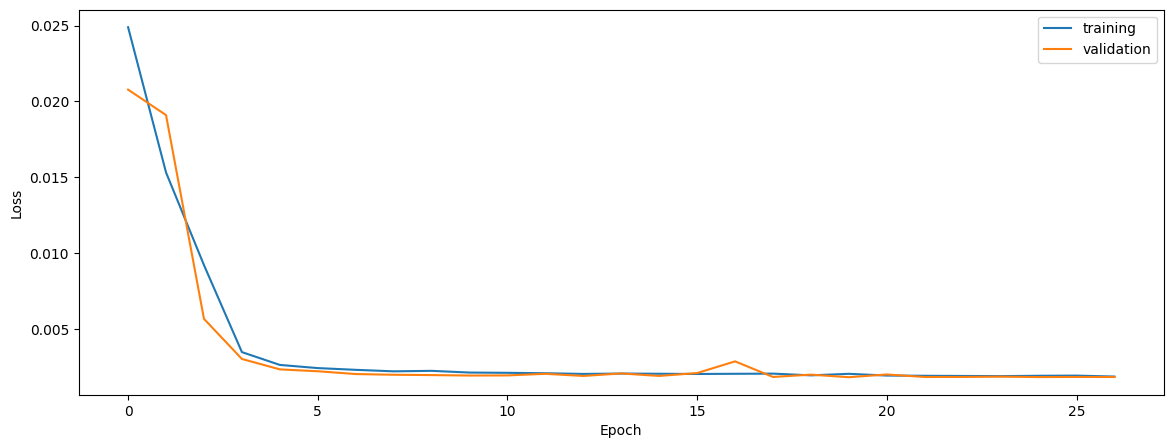

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9367641283262345
0.9550965426938116
0.9344117193677512


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9367641283262345
0.9550965426938116
0.9344117193677512


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9319919874957995
0.9486658208561844
0.935021789074064


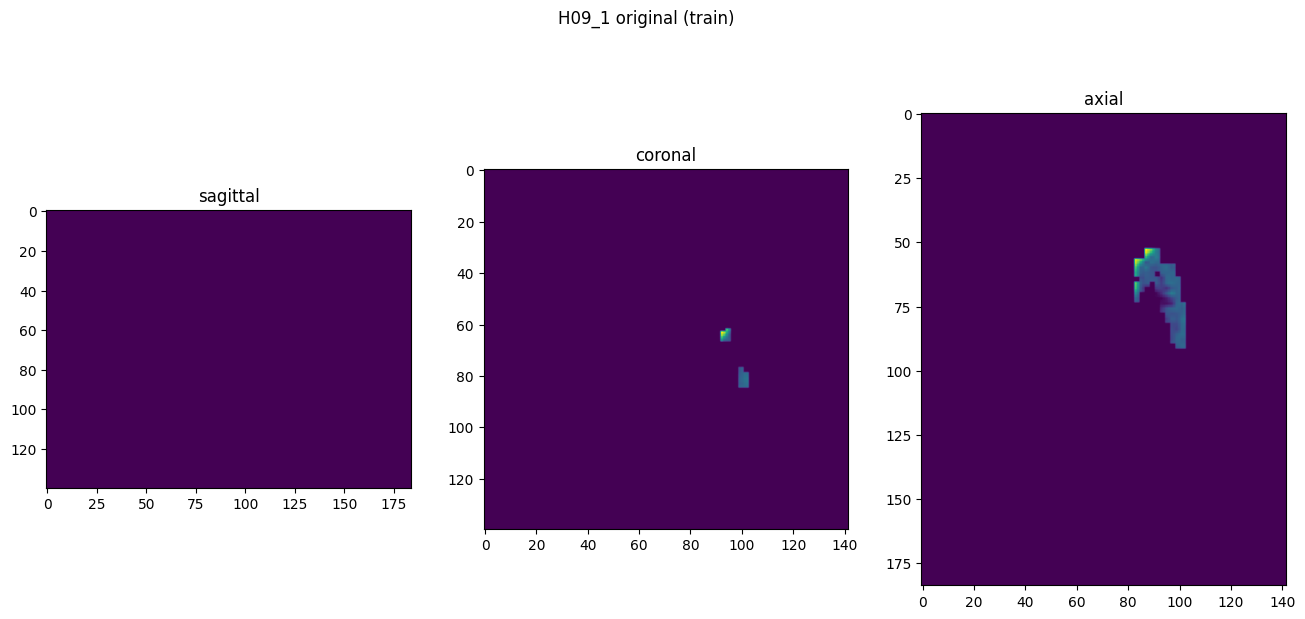

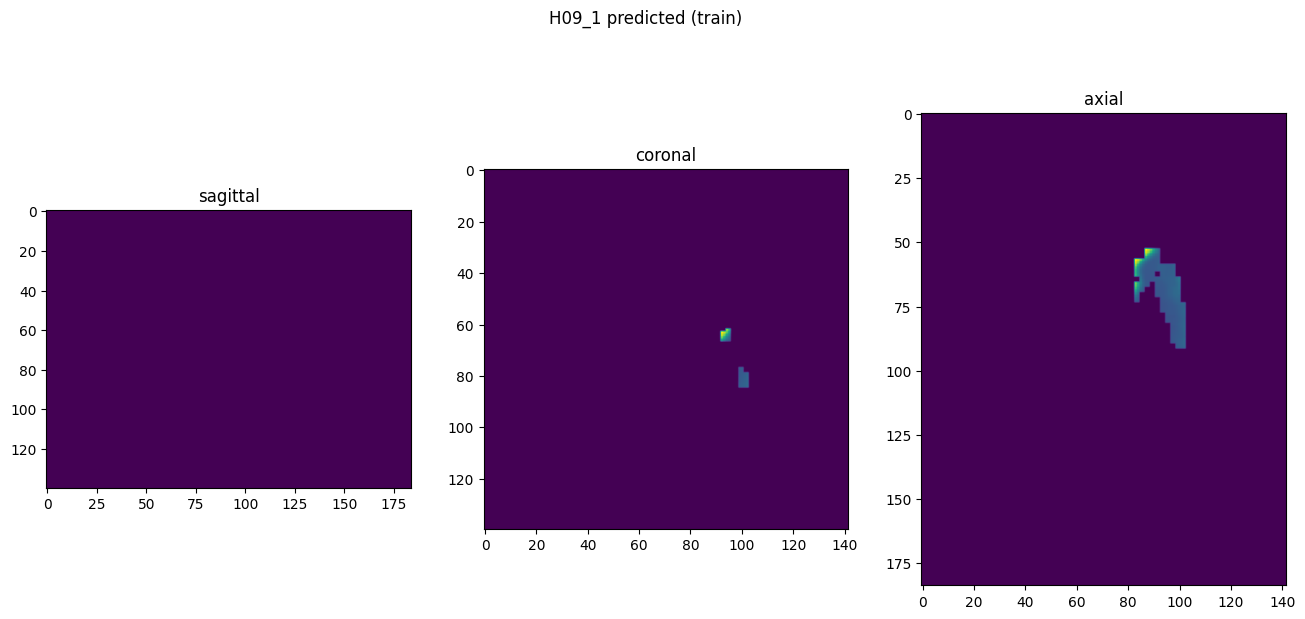

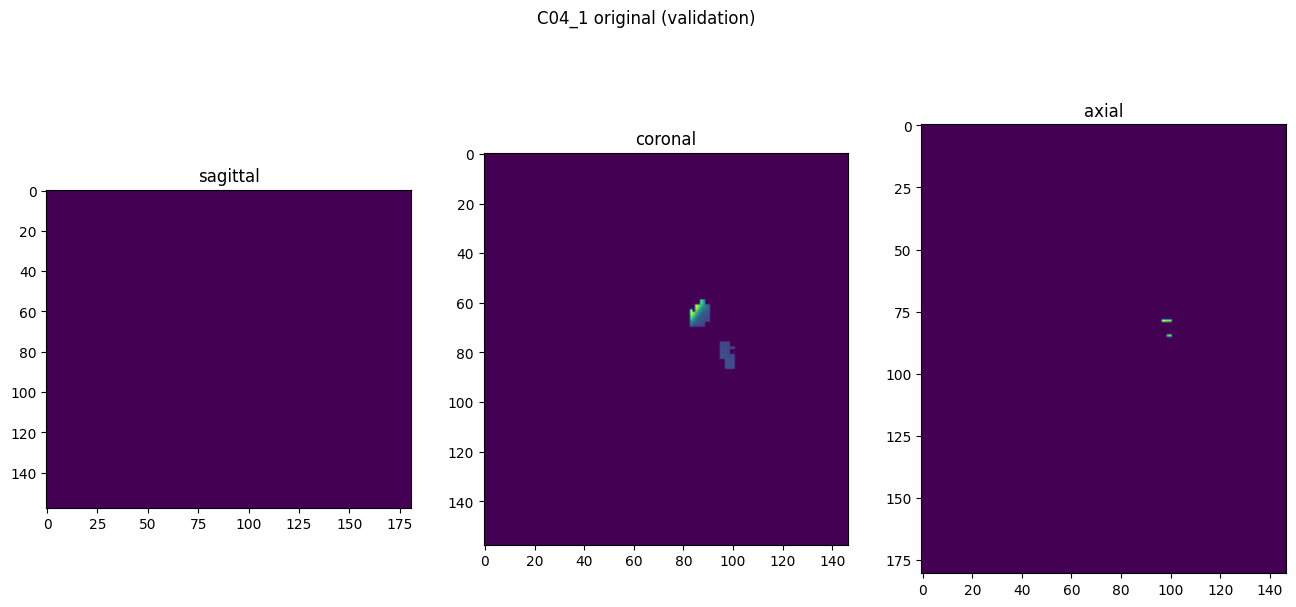

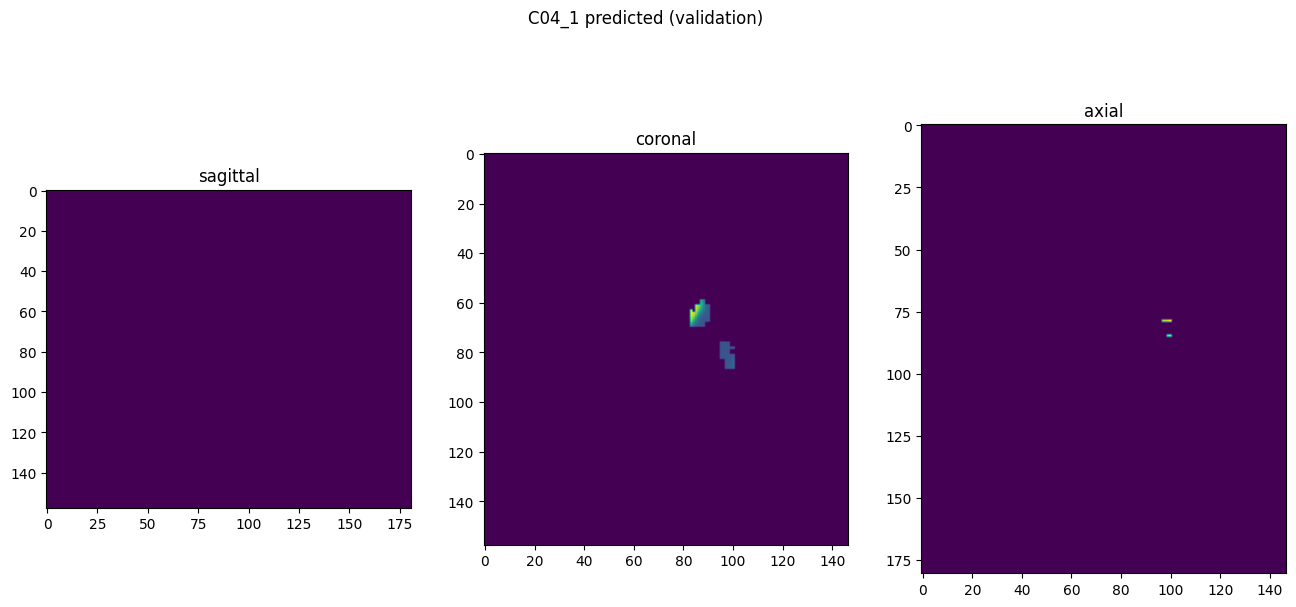

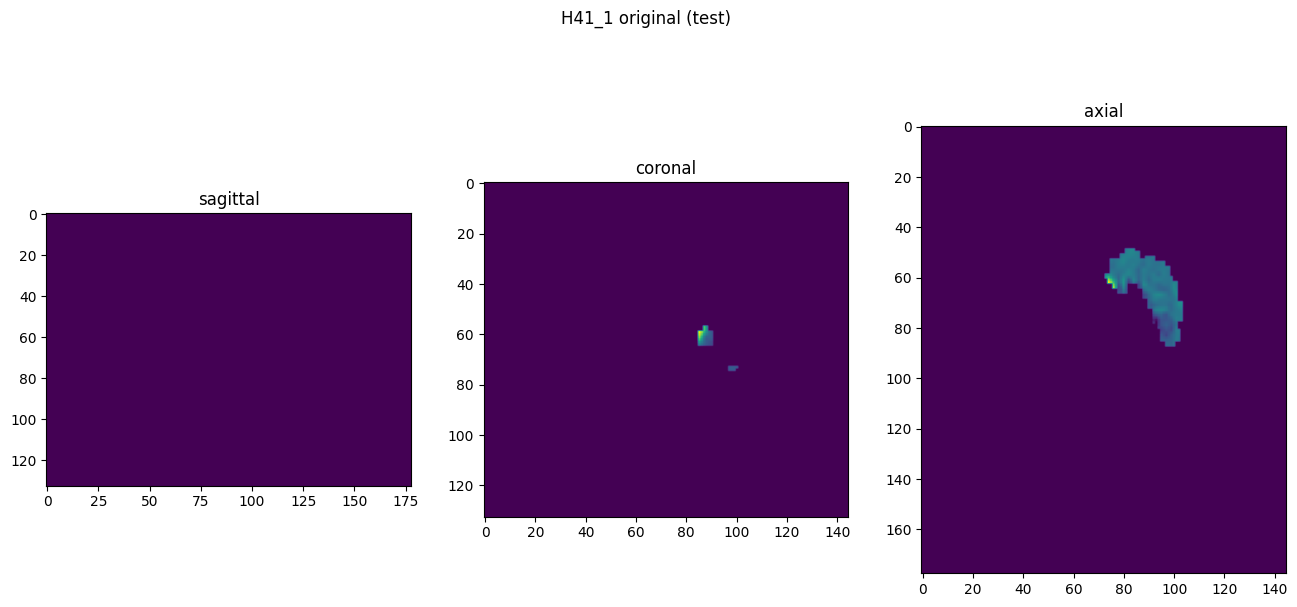

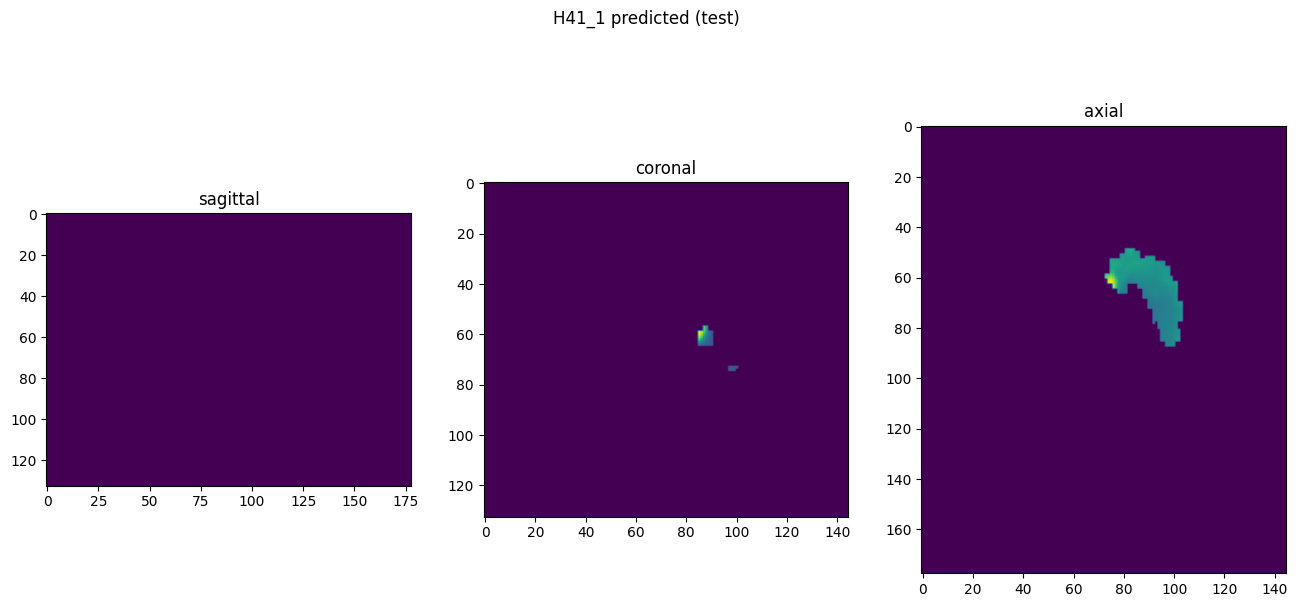

In [10]:
showResults(model, gen, threshold=None, background=False)